## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language models (for decoder and encoder)

* or just fine-tunning BART/ELECTRA/... ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [ ]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [ ]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
--2023-05-16 20:33:05--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.05s   

2023-05-16 20:33:07 (226 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [ ]:
Baseline solution BLEU score is quite low. Try to achieve at least __21__ BLEU on the test set. 
The checkpoints are:

* __21__ - minimal score to submit the homework, 30% of points

* __25__ - good score, 70% of points

* __27__ - excellent score, 100% of points

### Warning! The code below is deeeeeeeply deprecated and is is provided only as simple guide.
We suggest you to stick to most recent pipelines here, e.g. by Huggingface: 
* Example notebook: [link](https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb)
* Converting your own dataset to specific format: [link](https://discuss.huggingface.co/t/correct-way-to-create-a-dataset-from-a-csv-file/15686/15)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install torchtext==0.6.0
!pip install subword-nmt 
import sys
sys.path.append('/content/drive/MyDrive/MADE/NLP/lab2/')
import my_network
import bidir_RNN_attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# old deprecated code
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [ ]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [ ]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [ ]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [ ]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9299
Unique tokens in target (en) vocabulary: 6714


Here are tokens from original (RU) corpus:

In [ ]:
SRC.vocab.itos[::1000]

['<unk>',
 'легкие',
 'виллах',
 'кейптауна',
 'carmen',
 '1000',
 'links',
 'уличных',
 'даун',
 'страна']

And from target (EN) corpus:

In [ ]:
TRG.vocab.itos[::1000]

['<unk>', 'ceiling', 'groves', 'brought', 'mattala', 'singapore', 'mandala']

And here is example from train dataset:

In [ ]:
print(vars(train_data.examples[9]))

{'trg': ['the', 'hotel', 'also', 'features', 'in', '-', 'room', 'flat', '-', 'screen', 'tvs', 'and', 'daily', 'buffet', 'breakfast', '.'], 'src': ['кроме', 'того', ',', 'каждое', 'утро', 'для', 'гостей', 'сервируют', 'завтрак', '«', 'шведский', 'стол', '».']}


Let's check the length distributions:

Length distribution in Train data


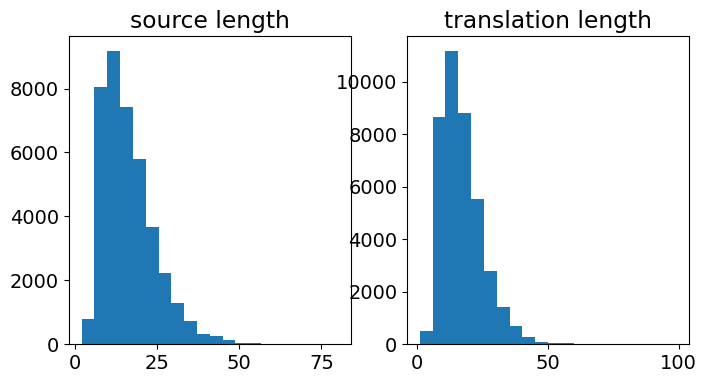

In [ ]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


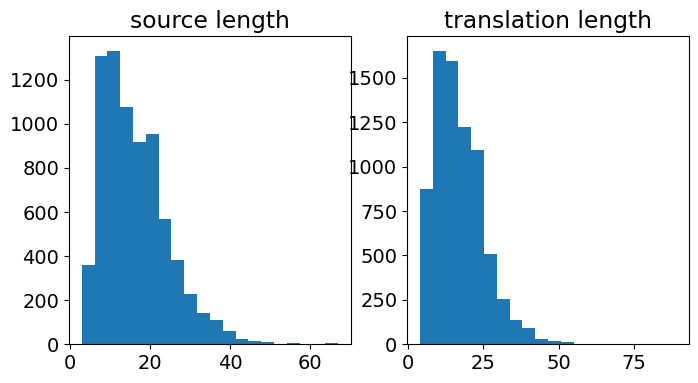

In [ ]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda', index=1)

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 52x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 48x128 (GPU 0)]
torch.Size([48, 128]) torch.Size([52, 128])


In [ ]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

NameError: ignored

In [ ]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9267, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6699, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6699, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,880,299 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None, hug_face_token=False):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        if hug_face_token:
            src = batch['source_input_ids'].to(device)
            trg = batch['target_input_ids'].to(device)
            
        else:
            src = batch.src
            trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

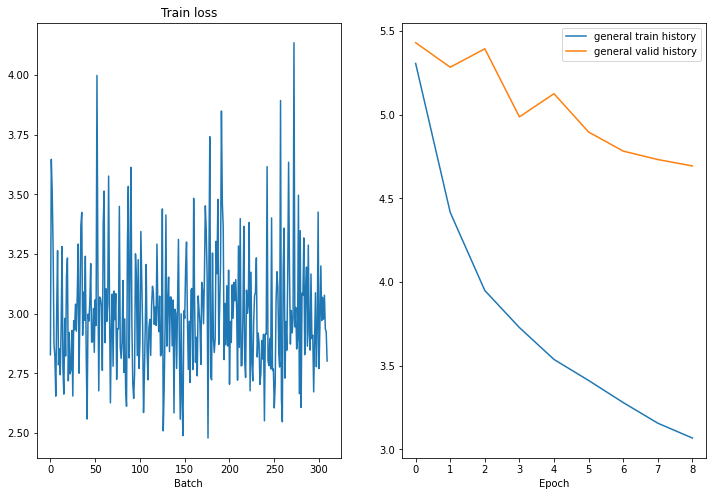

Epoch: 10 | Time: 1m 10s
	Train Loss: 2.998 | Train PPL:  20.040
	 Val. Loss: 4.710 |  Val. PPL: 111.007


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [ ]:
del utils

In [ ]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: there is a 24 - hour front desk at the property .
Generated: the property offers a 24 - hour front desk . .

Original: this property also features free wifi .
Generated: free wifi access . . . .



In [ ]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [ ]:
import tqdm

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:03, 18.87it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

14.139920232081806

# Realization of pretrained model from HuggingFaces

- Here is finetuning of "Helsinki-NLP/opus-mt-ru-en" checkpoint from HuggingFaces
- you will see the results at the end of this section

In [ ]:
# pip install datasets transformers[sentencepiece] sacrebleu

In [ ]:
# pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 6.5 MB/s eta 0:00:00


In [ ]:
import transformers
import pandas as pd
import datasets
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from torch.utils.tensorboard import SummaryWriter
from transformers.integrations import TensorBoardCallback
from random import randrange
from IPython.display import Image

### loading the dataset

In [ ]:
model_checkpoint = "Helsinki-NLP/opus-mt-ru-en"

In [ ]:
with open('/content/drive/MyDrive/MADE/NLP/lab2/data.txt', 'r') as f:
    content = f.read()

lines = content.splitlines()

data = []
for line in lines:
    if '.' in line:
        columns = line.split('.')  # Assuming tab-separated values, adjust the delimiter as per your file
    else:
        columns = line.split('\t')
    row = {'en': columns[0].strip(), 'ru': columns[1].strip()}  # Specify the column names accordingly
    data.append(row)


df = pd.DataFrame(data)
df.to_csv('data.csv', index=False)

In [ ]:
df.head()

,en,ru
0,"Cordelia Hotel is situated in Tbilisi, a 3-min...","Отель Cordelia расположен в Тбилиси, в 3 минут..."
1,At Tupirmarka Lodge you will find a 24-hour fr...,В числе удобств лоджа Tupirmarka круглосуточна...
2,"Featuring free WiFi in all areas, Naigao Xiaow...",Апартаменты Naigao Xiaowo расположены в городе...
3,Each has a TV and a private bathroom with shower,В вашем распоряжении также телевизор и собстве...
4,Your room comes with air conditioning and sate...,Номер оснащен кондиционером и спутниковым теле...


In [ ]:
from datasets import load_dataset, load_metric

# raw_datasets = load_dataset("wmt16", "ro-en")
metric = load_metric("sacrebleu")

dataset = load_dataset("csv", data_files="data.csv")

<ipython-input-7-d77f13ea9a63>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("sacrebleu")


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-721c713a1ec7b7ff/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Downloading the tokenizer
en_ru_dataset = dataset["train"].map(lambda ex, i: {"id": i, "translation": dict(ex)}, remove_columns=["en", "ru"], features=datasets.Features({"id": datasets.Value("string"), "translation": datasets
.Translation(languages=["en", "ru"])}), with_indices=True,)
en_ru_dataset = en_ru_dataset.train_test_split(test_size=0.2)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
source_lang = "ru"
target_lang = "en"
prefix = "translate Russian to English: "

Map:   0%|          | 0/38393 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
#tokenization of target and source language
def preprocess_function(examples):
    inputs = []
    targets = []
    k=0
    for example in examples["translation"]:
        if example[source_lang] is not None and example[target_lang] is not None and \
        len(example[source_lang].strip()) > 3 and len(example[target_lang].strip()) > 3:
            inputs.append(prefix + example[source_lang].strip())
            targets.append(example[target_lang].strip())
        else:
            k+=1
            # print("There is an issue with this segment:")
            # print("Source:", example[source_lang])
            # print("Target:", example[target_lang])
            random_num = randrange(10000)
            # print("Replaced with", random_num)
            inputs.append(prefix + str(random_num))
            targets.append(str(random_num))
    # print('examples', examples['translation'])
    print('k', k)
    model_inputs = tokenizer(inputs, max_length=128, truncation=True)
    print('model inputs', len(model_inputs["input_ids"]), len(model_inputs["input_ids"][0]))
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True)
        model_inputs["labels"] = labels["input_ids"]
    return model_inputs


tokenized_en_ru_dataset = en_ru_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

k 3
model inputs 1000 56


/home/b_gainitdinov/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:3606: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


k 2
model inputs 1000 28
k 1
model inputs 1000 25
k 4
model inputs 1000 36
k 2
model inputs 1000 61
k 3
model inputs 1000 35
k 0
model inputs 1000 42
k 3
model inputs 1000 58
k 0
model inputs 1000 30
k 2
model inputs 1000 33
k 2
model inputs 1000 53
k 3
model inputs 1000 44
k 3
model inputs 1000 30
k 5
model inputs 1000 34
k 1
model inputs 1000 27
k 0
model inputs 1000 37
k 2
model inputs 1000 52
k 3
model inputs 1000 42
k 1
model inputs 1000 54
k 3
model inputs 1000 48
k 4
model inputs 1000 42
k 4
model inputs 1000 53
k 2
model inputs 1000 66
k 5
model inputs 1000 44
k 2
model inputs 1000 28
k 1
model inputs 1000 25
k 2
model inputs 1000 34
k 3
model inputs 1000 31
k 2
model inputs 1000 35
k 0
model inputs 1000 32
k 3
model inputs 1000 46
k 1
model inputs 1000 41
k 2
model inputs 1000 41
k 1
model inputs 1000 44
k 3
model inputs 1000 34
k 2
model inputs 1000 36
k 3
model inputs 1000 45
k 5
model inputs 1000 38
k 3
model inputs 1000 39
k 2
model inputs 1000 40


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

k 2
model inputs 1000 34
k 1
model inputs 1000 96
k 3
model inputs 1000 61
k 2
model inputs 1000 42
k 3
model inputs 1000 30
k 1
model inputs 1000 40
k 7
model inputs 1000 50
k 2
model inputs 1000 36
k 3
model inputs 1000 51
k 1
model inputs 1000 49


In [ ]:
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import DataCollator

x = tokenized_en_ru_dataset['train']['input_ids'][:4]
len(x[0])
tokenized_en_ru_dataset['train']['translation'][0]

# x = DataLoader(x, batch_size=2)
# for i in x:
#     print(i)
#     break
# layer = nn.Embedding(9267, 256)
# layer(x)


# # Assuming you have a tokenized DatasetDict object called 'tokenized_dataset'
# # Create a data collator
# # data_collator = DataCollator()
# # Define a collate function to convert the dataset into batches
# def collate_fn(examples):
#     input_ids = [example['input_ids'] for example in examples]
#     attention_mask = [example['attention_mask'] for example in examples]
#     labels = [example['labels'] for example in examples]
#     return {
#         'input_ids': input_ids,
#         'attention_mask': attention_mask,
#         'labels': labels
#     }
# # Create a DataLoader
# dataloader = DataLoader(
#     tokenized_en_ru_dataset['train'],  # Assuming you want to use the 'train' split
#     batch_size=32,
#     collate_fn=collate_fn,
#     shuffle=True  # If you want to shuffle the data
# )
# for l in dataloader:
#     print(l)
#     break

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 5>:5                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'tokenized_en_ru_dataset' is not defined

### fine-tuning model

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
batch_size = 16
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-{source_lang}-to-{target_lang}",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=5,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
)

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
import numpy as np

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [ ]:
# Specify the log directory
log_dir = "logs"
# Create the SummaryWriter instance
writer = SummaryWriter(log_dir=log_dir)

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_en_ru_dataset["train"],
    eval_dataset=tokenized_en_ru_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[TensorBoardCallback(writer)]
)

You are adding a <class 'transformers.integrations.TensorBoardCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
TensorBoardCallback


In [ ]:
training_times = []

# Define a custom callback function to track training time
def track_training_time(training_args, trainer, **kwargs):
    epoch = kwargs["epoch"]
    if epoch > 0:
        elapsed_time = time.time() - training_times[-1]
        print(f"Training time for epoch {epoch}: {elapsed_time:.2f} seconds")
    training_times.append(time.time())

# Attach the custom callback function to the trainer
trainer.callback_training_begin = track_training_time

class LossCallback:
    def __init__(self):
        self.train_loss_history = []
        self.valid_loss_history = []

    def __call__(self, args, state, control, model, **kwargs):
        self.train_loss_history.append(state.global_step_metrics["train_loss"])
        self.valid_loss_history.append(state.global_step_metrics["eval_loss"])

# Create the callback instance
loss_callback = LossCallback()
trainer.CallbackHandler = loss_callback

In [ ]:
import time
trainer.train()

/home/b_gainitdinov/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/b_gainitdinov/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,1.989400,1.588191,29.467700,18.126400
2,1.626200,1.486434,31.240600,18.015000
3,1.518400,1.443250,31.837200,17.867900
4,1.406700,1.423379,32.278900,18.059200
5,1.373400,1.417022,32.466000,17.958100


/home/b_gainitdinov/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/b_gainitdinov/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/b_gainitdinov/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/b_gainitdinov/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gath

TrainOutput(global_step=3125, training_loss=1.5518716259765626, metrics={'train_runtime': 2879.5511, 'train_samples_per_second': 69.455, 'train_steps_per_second': 1.085, 'total_flos': 4042685102948352.0, 'train_loss': 1.5518716259765626, 'epoch': 5.0})

In [ ]:
# Access the loss history
train_loss_history = loss_callback.train_loss_history
valid_loss_history = loss_callback.valid_loss_history

In [ ]:
trainer.evaluate()

/home/b_gainitdinov/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 1.4381734132766724,
 'eval_bleu': 31.9506,
 'eval_gen_len': 17.7765,
 'eval_runtime': 369.5873,
 'eval_samples_per_second': 27.057,
 'eval_steps_per_second': 0.425,
 'epoch': 5.0}

In [ ]:
train_loss = trainer.train_loss_history
eval_loss = trainer.eval_loss_history
metrics = trainer.eval_metric_history

In [ ]:
from transformers import MarianMTModel, MarianTokenizer
src_text = ['My name is Sarah and I live in London']
model_name = 'opus-mt-en-ro-finetuned-en-to-ro/checkpoint-38000'
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)
translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True))
[tokenizer.decode(t, skip_special_tokens=True) for t in translated]

##### here are the images of tensorboard

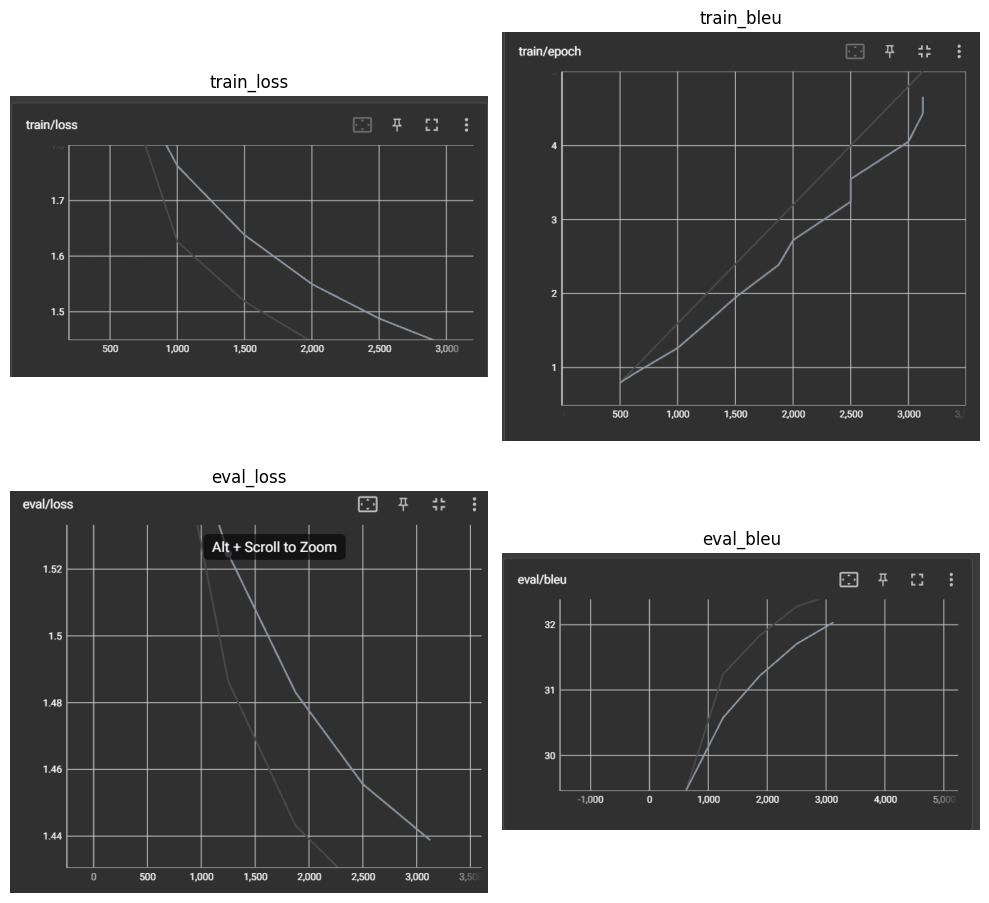

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Embedding first image
axes[0, 0].imshow(plt.imread('imgs/train_loss.png'))
axes[0, 0].set_title('train_loss')

# Embedding second image
axes[0, 1].imshow(plt.imread('imgs/train_bleu.png'))
axes[0, 1].set_title('train_bleu')

# Embedding third image
axes[1, 0].imshow(plt.imread('imgs/eval_loss.png'))
axes[1, 0].set_title('eval_loss')

# Embedding fourth image
axes[1, 1].imshow(plt.imread('imgs/eval_bleu.png'))
axes[1, 1].set_title('eval_bleu')

# Remove tick marks
for ax in axes.flatten():
    ax.axis('off')

plt.tight_layout()
plt.show()

#### results:
- bleu metric for 5 epochs=32.5
- 'train_runtime': 2879.5511
- see tensorboard screenshots, they were made in another notebook, thus here are only images

# Biderectional LSTM Attention mechanism
- here I tried too realize biderectional LSTM with attention mechanism, see bidir_RNN_attention.py notebook. 
- the pipeline is not finished

In [ ]:
from nltk.tokenize import WordPunctTokenizer

In [ ]:
pip install pytorch-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 5.7 MB/s eta 0:00:00


In [ ]:
import bidir_RNN_attention 
Encoder = bidir_RNN_attention.Encoder
Decoder = bidir_RNN_attention.Decoder
Seq2Seq = bidir_RNN_attention.Seq2Seq

In [ ]:
# Unique tokens in source (ru) vocabulary: 9267
# Unique tokens in target (en) vocabulary: 6699

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
INPUT_DIM = 9267
OUTPUT_DIM = 6699
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9267, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6699, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (attention): Attention(
      (linear_in): Linear(in_features=512, out_features=512, bias=False)
      (linear_out): Linear(in_features=1024, out_features=512, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (out): Linear(in_features=1024, out_features=6699, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (linear_long): Linear(in_features=1024, out_features=512, bias=True)
  (linear_short): Linear(in_features=1024, out_features=512, bias=True)
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 25,921,579 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)

    #scheduler.step(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

src
torch.Size([45, 128])


RuntimeError: ignored

In [ ]:
device

device(type='cuda')